# Introduction to PyTorch

In this assignment, we will use PyTorch, one of the most popular deep learning libraries out there. Similarly to programming languages, deep learning libraries can be very different in terms of syntax, yet they all revolve around the same concepts, so once you master one, learning another is much less challenging. We also use `seaborn` to plot charts and `scikit-learn` to download datasets. The three cells below should install, respectively:
1. PyTorch: `torch` and `torchvision`, version at least `1.13`
2. Seaborn
3. `scikit-learn` version at least `0.23`.

In [1]:
!pip install 'torch>=1.13' torchvision --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 11.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0


In [2]:
!pip install seaborn

In [3]:
!pip install 'scikit-learn>=0.23.0'

# Linear regression

## Data preparation

For this task we'll consider the problem of predicting houses prices in California. We begin by loading the dataset using `fetch_california_housing`. The returned object contains a few fields:

* `data` - the matrix of features
* `feature_names` - names of the features
* `target` - the values to predict

In [1]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

Let's see its description:

In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Now we convert the data to `torch.Tensor`, a PyTorch-specific representation of a tensor (a tensor is a generalization of a matrix to more than 2 dimensions). The `dtype` parameter forces conversion to floating-point numbers. The output of the cell is the size of the matrices. The output of the cell are the shapes of both tensors - `X` is 20640 rows by 8 columns and `y` is a vector of 20640 values

In [3]:
import torch

X = torch.tensor(dataset['data'], dtype=torch.float)
y = torch.tensor(dataset['target'], dtype=torch.float)

X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640]))

We then split the data randomly into three subsets: a training set consisting of 70\% of the learning examples, a validation set consisting of 10\% and a test set consisting of the remaining 20\%.

In [4]:
import torch.utils.data as data
training, validation, test = data.random_split(data.TensorDataset(X, y), [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 14448
Validation: 2064
Test: 4128


Let's inspect the first element of the training set - it is a pair of tensors, the first one consisting of 8 values (the features), whereas the second one is a tensor of a single value (the target)

In [5]:
training[0]

(tensor([ 5.6063e+00,  1.6000e+01,  6.4174e+00,  9.6957e-01,  1.5250e+03,
          3.3152e+00,  3.7450e+01, -1.2190e+02]),
 tensor(3.2050))

## Building a simple regressor

PyTorch is based on modules (objects of the class `torch.nn.Module`), which are composed into a compution graph. Each module may use parameters (objects of the class `torch.nn.Parameter`), and for each such an object it is possible to automatically compute gradients and optimize them according to some cost function.

We begin by constructing a single linear layer, that is, a layer implementing the operation $\hat{y} = Xw + b$

In [6]:
import torch.nn as nn

regressor = nn.Linear(8, 1) # 8 input features, 1 output feature

To evaluate the performance we use mean-squared error. While PyTorch offers a ready to use implementation as the class `torch.nn.MSELoss()`, this time we implement it manually as an example. The main point is to inherit from the class `torch.nn.Module` and then to override the method `forward`, which is responsible for performing computations in the forward direction of the computation graph. Computations in the backward direction (that is, gradient flow) are derrived automatically.

In [7]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

We would like to optimize the vector `w` and `b` automatically during the learning. To this end, we use the class `torch.optim.Adam`, which implements some extensions of the graident descent algorithm. We construct the object `opt`, which is responsible for optimizing the regressor's parameters, obtained by calling `regressor.parameters()`.

In [8]:
import torch.optim as optim

opt = optim.Adam(regressor.parameters())

## Starting computations

We implement mini-batch learning over `n_epoch` epochs. Within each epoch:
1. We shuffle the training set and iterate over it in the batches of `batch_size` examples
3. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
4. We execute the regressor and compute the mean-squared error (MSE).
5. We compute the gradients (`mse_value.backward()`) and apply them (`opt.step()`) to update the parameters of the regressor
6. We store the value of MSE. We call the `detach()` method to detach the MSE from its gradients. This enables passing the values to other libraries like `seaborn`.

After an epoch is completed, we average the collected MSEs and store the value.

In [9]:
import numpy as np

mse_values = []
batch_size = 100
n_epoch = 10
for epoch in range(n_epoch):    
    mse_epoch = []
    for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):        
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.item())
    mse_values.append(np.mean(mse_epoch))    

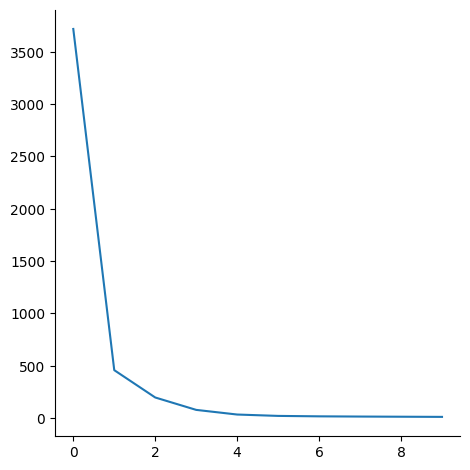

In [10]:
import seaborn as sns

_ = sns.relplot(x=range(len(mse_values)), y=mse_values, kind="line")

Execute the two preceeding cells of the code again. Because the regressor and the optimizer were not created anew, so the parameters are already optimized and the obtained charts are vastly different. In order to return to the initial state it is necessary to create new obiect `regressor` and `opt`.

## Task 1: Early stopping

Complete the function `train_linear_regression` implementing the early stopping: after each epoch of learning compute the value of MSE using the sets `X_validation` and `y_validation`. Keep track of the epoch number you got the best value of the MSE on the validation set so far. Stop the learning process if that epoch is at least `no_improvment` epochs in the past. Store MSE for validation in the `validation_mses` list and return it along with the trained regressor.

Hints and remarks:
* Observe that we must call the methods `regressor.train()` and `regressor.eval()` to switch the module between the training mode and the evaluation mode. 
* Remeber not to call `opt.step()` after performing the computation on the validation set, to not update the weights of the model. Similarly, you don't need to compute gradients during this step.
* You don't need to shuffle the validation set, nor go over it using batches. Instead, you can access the underlying tensors: `validation[:][0]` gets you the X matrix, whereas `validation[:][1]` returns the y vector.
* You may want to print out the epoch number and the value of the MSE on the validation set every time you find a better value. In the beginning you should expect a better value more or less every epoch and the decrease in MSE will be step, with time the decreases will diminishi and you'll hit a better value only every few epochs

In [11]:
def train_linear_regression(training: data.Dataset, 
                      validation: data.Dataset, 
                      n_features: int | None = None, 
                      no_improvement: int = 10,
                      batch_size: int = 128,
                      max_epochs: int = 100_000):

    if n_features is None:
        n_features = training[0][0].shape[0]
    regressor = nn.Linear(n_features, 1) # n_features input features, 1 output feature
    opt = optim.Adam(regressor.parameters())

    training_mses = []
    validation_mses = []
    no_improvement_counter = 0
    best_validation_mse = float('inf')
    
    X_validation = validation[:][0]
    y_validation = validation[:][1]

    for epoch in range(max_epochs):
        regressor.train()
        mse_epoch = []
        for X_batch, y_batch in data.DataLoader(training, batch_size=batch_size, shuffle=True):
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            mse_value = mse(y_pred, y_batch)
            mse_value.backward()
            opt.step()
            mse_epoch.append(mse_value.item())

        training_mses.append(np.mean(mse_epoch))
            
        regressor.eval()
        # put torch into inference mode for better performance
        with torch.inference_mode():
            # make predictions
            y_pred = regressor(X_validation)

            # calculate loss
            mse_value = mse(y_pred, y_validation)
            validation_mses.append(mse_value.item())

            # update no_improvement_counter
            if best_validation_mse > mse_value:
                no_improvement_counter = 0
                best_validation_mse = mse_value
            else:
                no_improvement_counter += 1

            # break if no_improvement is satisfied
            if no_improvement_counter >= no_improvement:
                break
        
    return regressor, validation_mses

Let's test your solution. First, we train the regressor.

In [12]:
# for reproducibility
torch.manual_seed(17)

regressor, validation_mses = train_linear_regression(training, validation)

We plot the last 40 values of MSE on the validation set. If you implemented the early stopping correctly, the lowest value should be exactly at 30 (`=40-no_imporvement`)

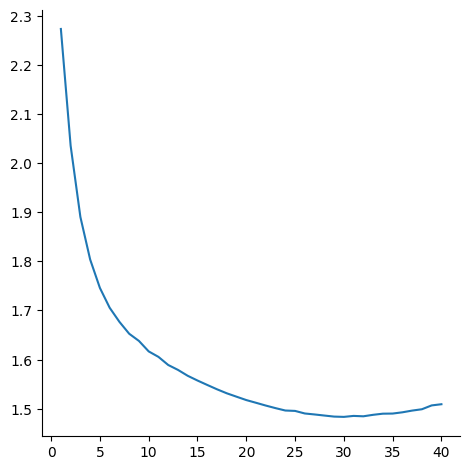

In [13]:
_ = sns.relplot(x=range(1, 41), y=validation_mses[-40:], kind="line")

Finally, let's compute the mse on the test set. It should be similar to those we got on the validation set.

In [14]:
regressor.eval()
y_pred = regressor(test[:][0]).reshape((-1,))
print("MSE on the test set:", mse(y_pred, test[:][1]).item())

MSE on the test set: 0.9649956226348877


# Classification

The second part is concerned with the classification task. We begin by downloading the MNIST dataset, consisting of 70.000 examples of handwritten digits (0-9), represented as grayscale images of 28x28 pixels. We use the function `fetch_openml` that downloads the data from [https://www.openml.org/](https://www.openml.org).

In [15]:
from sklearn.datasets import fetch_openml
mnist_sklearn = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

Let's learn something about the dataset

In [16]:
print(mnist_sklearn.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
X = torch.tensor(mnist_sklearn.data, dtype=torch.float, device=device)
y = torch.tensor([int(v) for v in mnist_sklearn.target], device = device)
mnist = data.TensorDataset(X, y)

Lets inspect some examples. The digit in the top-right corner of each image is not a part of the image itself, but rather the label of the image, displayed using `ax.text` in the code below. For the visualisation we use `matplotlib`, a library underlying the `seaborn` library.

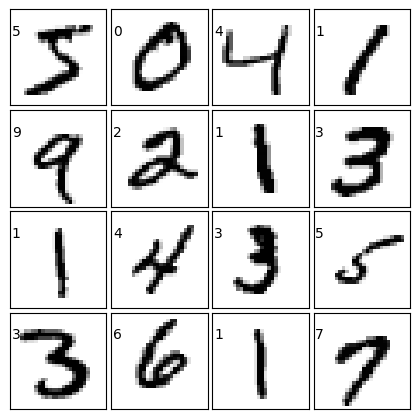

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (4,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(mnist[i][0].reshape(28, 28).cpu(),cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(mnist[i][1].item()))

We again split the dataset into three subsets.

In [20]:
training, validation, test = data.random_split(mnist, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))

print("Training:", len(training))
print("Validation:", len(validation))
print("Test:", len(test))

Training: 49000
Validation: 7000
Test: 14000


## Logistic regression

We create a simple logisitc regression model, learning on the raw pixels of the images. The matrix of the feature weights (here: pixels) is of the size $p \times k$, i.e., $p$ weights for each of the $k$ classes. The model computes logits, i.e., the output of the logistic  regression **before** applying the softmax function. In the output, each row corresponds to a single example and each column to a single class. Should each row be normalized using the softmax function, each row would be a probability distribution.

In [21]:
p = 28*28
k = 10
model = nn.Linear(p, k)

As the loss function we will use *cross entropy* and perform the optimization using the Adam optimizer. Observe that the optimizer gets the set of parameters to optimize. If you create a new model, you could reuse the old `loss_function`, but the optimizer must be created anew.

In [22]:
loss_function = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

We create an auxiliary function to compute the classification accuracy. For each row of the `logits` matrix we select the number of the column with the highest value and compare it with the expected (true) value. This way we obtain a vector of 0s and 1s, which are then averaged to compute the accuracy.

In [23]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

The remainder is very similar to the linear regression: we create a data loder (`torch.utils.data.DataLoader`)  to handle shuffling and creating batches for us, and then during each of the `n_epoch` epochs, we enable the training mode (`model.train()`), and then iterate over the loader, computing loss and gradients. Then we evaluate by computing the accuracy on the validation set.

In [24]:
loss_values = []
acc_values = []
batch_size = 512
n_epoch = 10

In [25]:
# for reproducitibility 
torch.manual_seed(17)
torch.cuda.manual_seed(17)

loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)    

model.to(device)

for epoch in range(n_epoch):    
    model.train()    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = loss_function(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(validation[:][0])
    acc = compute_acc(logits, validation[:][1]).item()
    print("Epoch:", epoch, "accuracy:", acc)
    acc_values.append(acc)

Epoch: 0 accuracy: 0.8645713925361633
Epoch: 1 accuracy: 0.8788571357727051
Epoch: 2 accuracy: 0.8837142586708069
Epoch: 3 accuracy: 0.8904285430908203
Epoch: 4 accuracy: 0.885857105255127
Epoch: 5 accuracy: 0.8782857060432434
Epoch: 6 accuracy: 0.8917142748832703
Epoch: 7 accuracy: 0.883571445941925
Epoch: 8 accuracy: 0.8905714154243469
Epoch: 9 accuracy: 0.8895714282989502


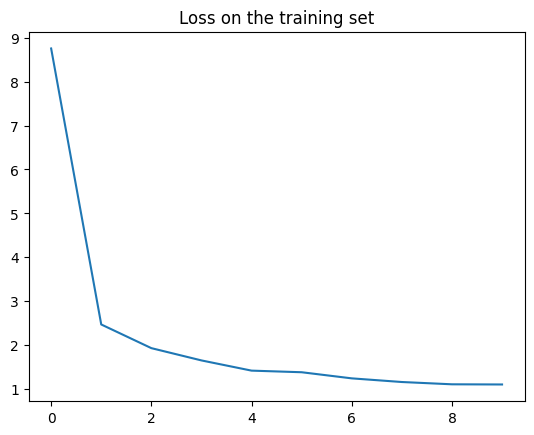

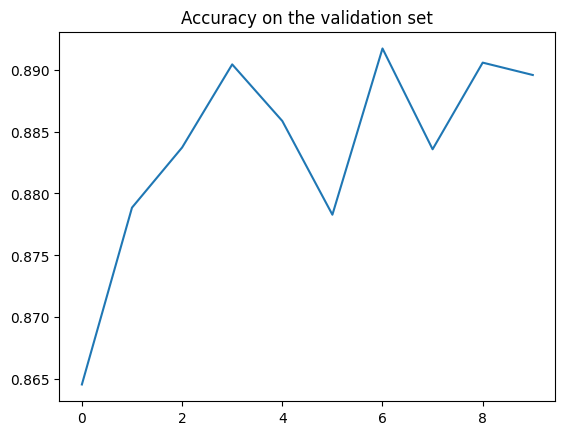

In [26]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

Observe that the first epoch already gets us very high and then the improvements are very small.

## Task 2: Learning framework

The function `train_classifier` below is supposed to be an integrated tool for fitting parameters of the given `model`. Complete the function below so that it:

* Trains `model` using the training set (`training`) for at most `max_epochs` using the mini-batches of the `batch_size` size
* Implements early stopping using the validation set (`validation`), stopping if there is no improvement on accuracy for `no_improvement` epochs
* Returns a list such that i-th element of this list is the accuracy on the validation set after the i-th epoch of training
* Use the cross-entropy loss and the Adam optimizer for training, but make sure you don't reuse the global objects `loss_function` and `opt`
* Remember to switch between the training mode (`model.train()`) and the evaluation mode (`model.eval()`)

In [30]:
def train_classifier(model: nn.Module,        
              training: data.Dataset, 
              validation: data.Dataset,
              no_improvement: int = 10,
              batch_size: int = 128,
              max_epochs: int = 100_000):
    # initial objects
    loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), 0.0001)
    loss_function = torch.nn.CrossEntropyLoss()

    # for early stopping
    best_accuracy = 0
    no_improvement_counter = 0

    # to return
    acc_values = []
    for epoch in range(max_epochs):    
        model.train()    
        for X_batch, y_batch in loader:
            # move to data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # zero the gradients in parameters
            optimizer.zero_grad()

            # calculate and backpropagate loss
            logits = model(X_batch)
            loss = loss_function(logits, y_batch)
            loss.backward()

            # make a step
            optimizer.step()

        model.eval()
        with torch.inference_mode():
            logits = model(validation[:][0])
            acc = compute_acc(logits, validation[:][1]).item()
            acc_values.append(acc)

            if best_accuracy < acc:
                best_accuracy = acc
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            if no_improvement_counter >= no_improvement:
                break

    return acc_values 

Test it by training logistic regression on the MNIST dataset and then plotting the accuracies. The best accuracy should be on the 10-th epoch from the end.

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
%%time

# for reproducibility
torch.manual_seed(17)
torch.cuda.manual_seed(17)

model = nn.Linear(28*28, 10, device=device)
accuracies = train_classifier(model, training, validation)

CPU times: user 34.1 s, sys: 398 ms, total: 34.5 s
Wall time: 29.5 s


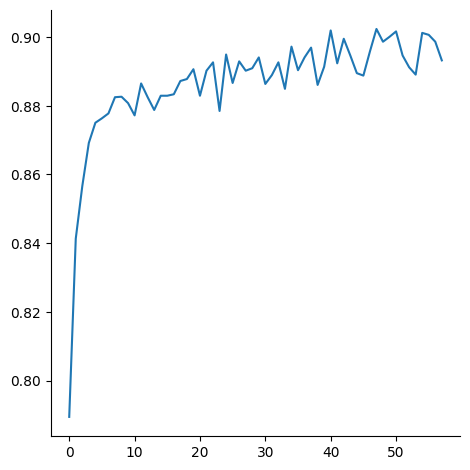

In [33]:
_ = sns.relplot(x=range(len(accuracies)), y=accuracies, kind="line")

## Task 3: A neural network with a hidden layer

Complete the cell below to create a neural network consisting of the following layers:
  1. Linear layer (`nn.Linear`) having `28*28` inputs and `300` outputs
  2. ReLU activation function (`nn.ReLU`)
  3. Dropout layer (`nn.Dropout`) with the probability of `0.5`
  4. Linear layer (`nn.Linear`) having `10` outputs
To combine layers into a single model use `nn.Sequential` 

If you haven't found it so far, the documentation for the `torch.nn` module may now be of use: [https://pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html)

In [34]:
model = nn.Sequential(
    nn.Linear(28 * 28, 300),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(300, 10)
).to(device)

In [35]:
%%time

accuracies = train_classifier(model, training, validation)
print("The best accurac on the validation set:", max(accuracies))

The best accurac on the validation set: 0.9815714359283447
CPU times: user 1min 29s, sys: 891 ms, total: 1min 30s
Wall time: 1min 22s


## Task 4: Play with it!

Construct at least 6 substantially different models (use common sense - e.g., changing the number of neurons from 300 to 301 is not a substantial change). Make sure you not only consider different hyperparameters (e.g., changing the number of neurons, changing the activation function), but also different architectures (e.g., adding/removing a layer). Train them using `train_classifier` and evaluate them all on the test subset of MNIST using the accuracy measure. **Print out these accuracies and indicate which model is the best.**

If you want and can you can use other types of layers (e.g., convolutional layers), but please stick to what's available in PyTorch. The current state of the art on the MNIST dataset is around 99.9% accuracy [https://paperswithcode.com/sota/image-classification-on-mnist](https://paperswithcode.com/sota/image-classification-on-mnist).

In [47]:
%%time
torch.manual_seed(17)
torch.cuda.manual_seed(17)

best_accuracies = []

model = nn.Sequential(
    nn.Linear(28 * 28, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {0}')
print("Input 784, Linear 10, Sigmoid, Linear 10")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()

model = nn.Sequential(
    nn.Linear(28 * 28, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {1}')
print("Input 784, Linear 10, ReLU, Linear 10")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()

model = nn.Sequential(
    nn.Linear(28 * 28, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 10),
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {2}')
print("Input 784, Linear 10, LeakyReLU, Linear 10)")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()


model = nn.Sequential(
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 10),
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {3}')
print("Input 784, Linear 500, ReLU, Linear 500)")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()

model = nn.Sequential(
    nn.Linear(28 * 28, 300),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(300, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {4}')
print("Input 784, Linear 300, ReLU, Dropout 0.5, Linear 10, ReLU, Linear 10, ReLU, Linear 10)")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()


model = nn.Sequential(
    nn.Linear(28 * 28, 28 * 28),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(28 * 28, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 10)
).to(device)
accuracies = train_classifier(model, training, validation)
print(f'Model {5}')
print("Convolution, Input 784, Linear 784, LeakyReLU, Dropout 0.5, Linear 10, LeakyReLU, Linear 10")
best_accuracies.append(max(accuracies))
print("The best accuracy on the validation set:", best_accuracies[-1])
print()


print("Best accuracies of the models on validation set:", best_accuracies)
print("Best model:", np.argmax(np.array(best_accuracies)))

Model 0
Input 784, Linear 10, Sigmoid, Linear 10
The best accuracy on the validation set: 0.8912857174873352

Model 1
Input 784, Linear 10, ReLU, Linear 10
The best accuracy on the validation set: 0.9208571314811707

Model 2
Input 784, Linear 10, LeakyReLU, Linear 10)
The best accuracy on the validation set: 0.9298571348190308

Model 3
Input 784, Linear 500, ReLU, Linear 500)
The best accuracy on the validation set: 0.9808571338653564

Model 4
Input 784, Linear 300, ReLU, Dropout 0.5, Linear 10, ReLU, Linear 10, ReLU, Linear 10)
The best accuracy on the validation set: 0.9814285635948181

Model 5
Convolution, Input 784, Linear 784, LeakyReLU, Dropout 0.5, Linear 10, LeakyReLU, Linear 10
The best accuracy on the validation set: 0.9827142953872681

Best accuracies of the models on validation set: [0.8912857174873352, 0.9208571314811707, 0.9298571348190308, 0.9808571338653564, 0.9814285635948181, 0.9827142953872681]
Best model: 5
CPU times: user 4min 55s, sys: 3.41 s, total: 4min 58s
Wall

----
Some final remarks:
* PyTorch also offers autoloading some datasets, see e.g. [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)
* Early stopping should also save the parameters of the best model and restore them upon termination. I decided to skip this part to avoid adding yet another opaque piece. If you are interested see [https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)
* As all deep learning libraries, PyTorch offers support for offloading computation to GPU. In practice the difference is tremendous, but you need a graphics card supporting CUDA, i.e., an Nvidia card. Since this is a rather restrictive requirement, I elected not to introduce this aspect. If you are interested, see e.g. [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). If you don't have an Nvidia card, there are services out there that will allow you to access one for free for a short time, e.g., Google Colab [https://colab.research.google.com/](https://colab.research.google.com/) or Paperspace Gradient [https://www.paperspace.com/gradient/free-gpu](https://www.paperspace.com/gradient/free-gpu).
* *Layer* is a vague term. It could be argued that neither dropout nor relu by themselves are layers, but rather they form a single layer together with `nn.Linear`. In here, I elected to follow the same naming convention that is used in the PyTorch documentation.